In [1]:
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

In [2]:
def parse_mnist(path):
    with open(path, 'rb') as f:
        contents = f.read()
    assert contents[0] == contents[1] == 0 # magic number
    assert contents[2] == 0x08 # unsigned byte
    dims = contents[3]
    shape = [int.from_bytes(contents[d:d+4], 'big')
             for d in range(4, dims*4+1, 4)]
    return jnp.frombuffer(bytearray(contents), offset=4*dims+4,
                         dtype=np.ubyte).reshape(shape).astype(jnp.float32)

In [3]:
images = parse_mnist('data/train-images-idx3-ubyte').reshape(-1, 784) / 255.0

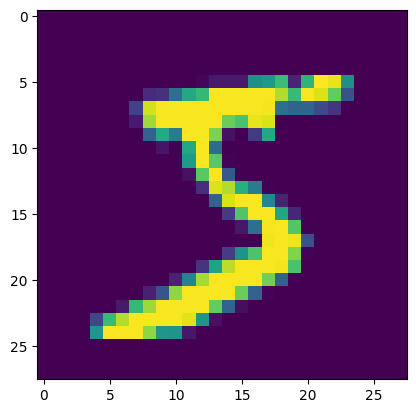

In [4]:
plt.imshow(images[0].reshape(28, 28))
plt.show()

In [5]:
labels = jax.nn.one_hot(parse_mnist('data/train-labels-idx1-ubyte'), 10)

In [6]:
labels[0]

Array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [7]:
initializer = jax.nn.initializers.glorot_uniform()
keys = jax.random.split(jax.random.PRNGKey(0), 3)
params = [
    {'w': initializer(keys[0], (784,512), jnp.float32), 'b': jnp.ones((512,), jnp.float32)},
    {'w': initializer(keys[1], (512,256), jnp.float32), 'b': jnp.ones((256,), jnp.float32)},
    {'w': initializer(keys[2], (256,10), jnp.float32), 'b': jnp.ones((10,), jnp.float32)}
]

In [8]:
@jax.jit
def forward(params, x):
    *hidden_layers, last = params
    for hidden_layer in hidden_layers:
        x = jax.nn.relu(x @ hidden_layer['w'] + hidden_layer['b'])
    return x @ last['w'] + last['b']

batch_forward = jax.jit(jax.vmap(forward, in_axes=(None,0)))

@partial(jax.jit, static_argnames=['c'])
def loss_fn(params, xs, ys, c=1e-4):
    preds = batch_forward(params, xs)
    l2_reg = optax.l2_loss(preds).sum().sum()
    cross_entropy = optax.softmax_cross_entropy(preds, ys).mean() 
    return cross_entropy + c*l2_reg

In [9]:
@partial(jax.jit, static_argnames=['optimizer'])
def update(params, xs, ys, optimizer, opt_state):
    loss, grad = jax.value_and_grad(loss_fn)(params, xs, ys)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [10]:
ITERATIONS = 1000
BATCH_SIZE = 64
losses = []

batch_indices = np.random.choice(range(len(images)), (ITERATIONS, BATCH_SIZE))

optimizer = optax.adam(0.001)
opt_state = optimizer.init(params)

for i in tqdm(range(ITERATIONS)):
    params, opt_state, loss = update(params,
                               images[batch_indices[i]],
                               labels[batch_indices[i]],
                               optimizer, opt_state)
    losses.append(loss.tolist())

100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 130.39it/s]


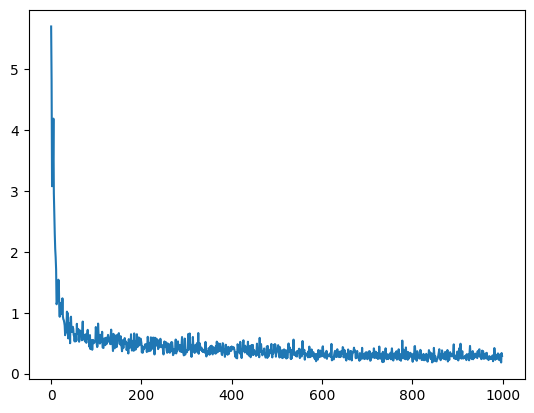

In [11]:
plt.plot(losses)
plt.show()

In [12]:
batch_indices = np.random.choice(range(len(images)), 10000)
accuracy = (jnp.argmax(batch_forward(params, images[batch_indices]), axis=-1) == jnp.argmax(labels[batch_indices], axis=-1)).mean()
accuracy.tolist()

0.9698999524116516

In [13]:
import haiku as hk

In [14]:
images = images.reshape(-1, 28, 28, 1)

In [15]:
def net_fn(x):
    net = hk.Sequential([
        hk.Conv2D(32, 4, 2), jax.nn.relu,
        hk.Flatten(),
        hk.Linear(256), jax.nn.relu,
        hk.Linear(10)
    ])
    return net(x)

In [16]:
net = hk.without_apply_rng(hk.transform(net_fn))
params = net.init(jax.random.PRNGKey(0), images[0:2])

In [17]:
@partial(jax.jit, static_argnames=['net'])
def forward(params, net, xs):
    return net.apply(params, xs)

@partial(jax.jit, static_argnames=['net', 'c'])
def loss_fn(params, net, xs, ys, c=1e-4):
    preds = forward(params, net, xs)
    l2_reg = optax.l2_loss(preds).sum().sum()
    cross_entropy = optax.softmax_cross_entropy(preds, ys).mean() 
    return cross_entropy + c*l2_reg

@partial(jax.jit, static_argnames=['net', 'optimizer'])
def update(params, net, xs, ys, optimizer, opt_state):
    loss, grad = jax.value_and_grad(loss_fn)(params, net, xs, ys)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [18]:
ITERATIONS = 1000
BATCH_SIZE = 64
losses = []

batch_indices = np.random.choice(range(len(images)), (ITERATIONS, BATCH_SIZE))

optimizer = optax.adam(0.001)
opt_state = optimizer.init(params)

for i in tqdm(range(ITERATIONS)):
    params, opt_state, loss = update(params, net,
                               images[batch_indices[i]],
                               labels[batch_indices[i]],
                               optimizer, opt_state)
    losses.append(loss.tolist())

100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.67it/s]


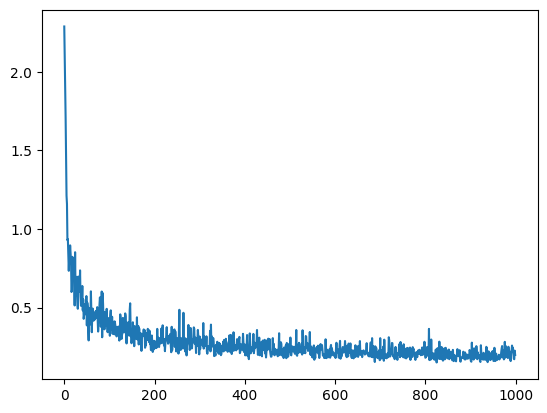

In [19]:
plt.plot(losses)
plt.show()

In [20]:
batch_indices = np.random.choice(range(len(images)), 10000)
accuracy = (jnp.argmax(forward(params, net, images[batch_indices]), axis=-1) == jnp.argmax(labels[batch_indices], axis=-1)).mean()
accuracy.tolist()

0.9872999787330627